In [34]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
import librosa
import librosa.display
import glob

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df=pd.read_csv("C:/jenre/metadata2.csv")

In [3]:
df

,FileName,Class
0,blues.00000.wav,blues
1,blues.00001.wav,blues
2,blues.00002.wav,blues
3,blues.00003.wav,blues
4,blues.00004.wav,blues
...,...,...
694,reggae.00095.wav,reggae
695,reggae.00096.wav,reggae
696,reggae.00097.wav,reggae
697,reggae.00098.wav,reggae


Class
blues        100
classical    100
country      100
metal        100
pop          100
reggae       100
jazz          99
Name: count, dtype: int64


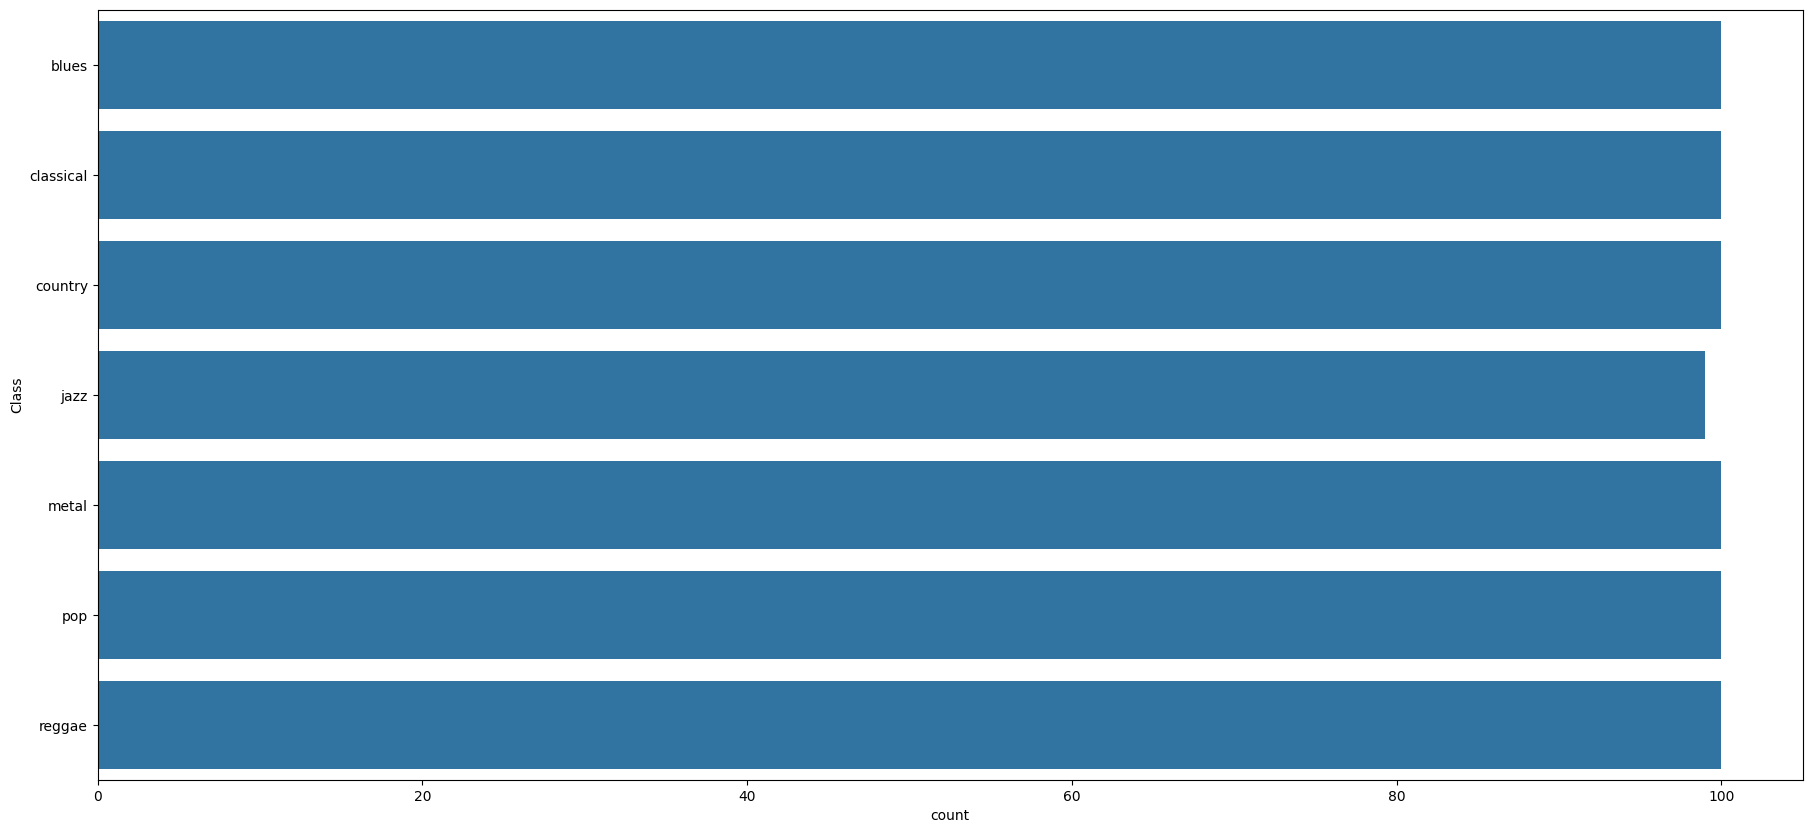

In [4]:
# Visualizing Tag column

print(df['Class'].value_counts())
plt.figure(figsize=(22,10))
sns.countplot(df['Class'])
plt.xticks(rotation=0)

plt.show()

In [5]:
df.set_index('FileName',inplace=True)

for f in df.index:
    rate, signal = wavfile.read('C:/jenre/GATZAN/' + f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.Class))
class_dist = df.groupby(['Class'])['length'].mean()

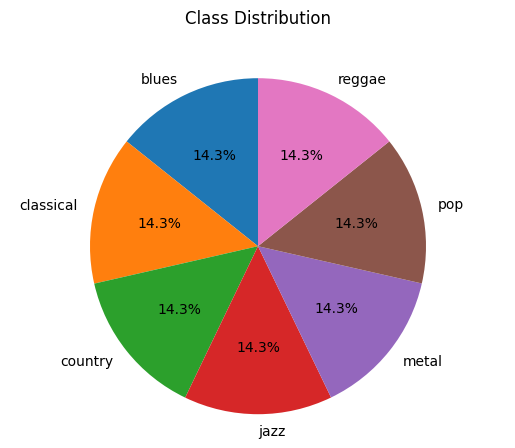

In [6]:
# Volume of each labels

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()
df.reset_index(inplace=True)

In [7]:
# Calculate FFT

def calc_fft(y,sr):
    
    n=len(y)
    freq=np.fft.rfftfreq(n,d=1/sr)
    Y=abs(np.fft.rfft(y)/n)
    return (Y,freq)

In [8]:
# Valuable Info In Sample

def Envelope(y, rate, threshold):
    mask = []
    #we want a rolling window so we create series as it is easy with it
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/4), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
            
    return mask

In [9]:
# Taking One Audio from each class 
# Applying some FE methods

signals = {}
fft = {}
fnames=[]
mfccs = {}


for c in classes:
    wav_file = df[df.Class == c].iloc[0,0]
    fnames.append('C:/jenre/GTZAN/'+wav_file)
    signal, rate = librosa.load('C:/jenre/GTZAN/'+wav_file,sr=44100)
    mask = Envelope(signal, rate, 0.0005) #0.0005 is experimental
    signal = signal[mask]
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)

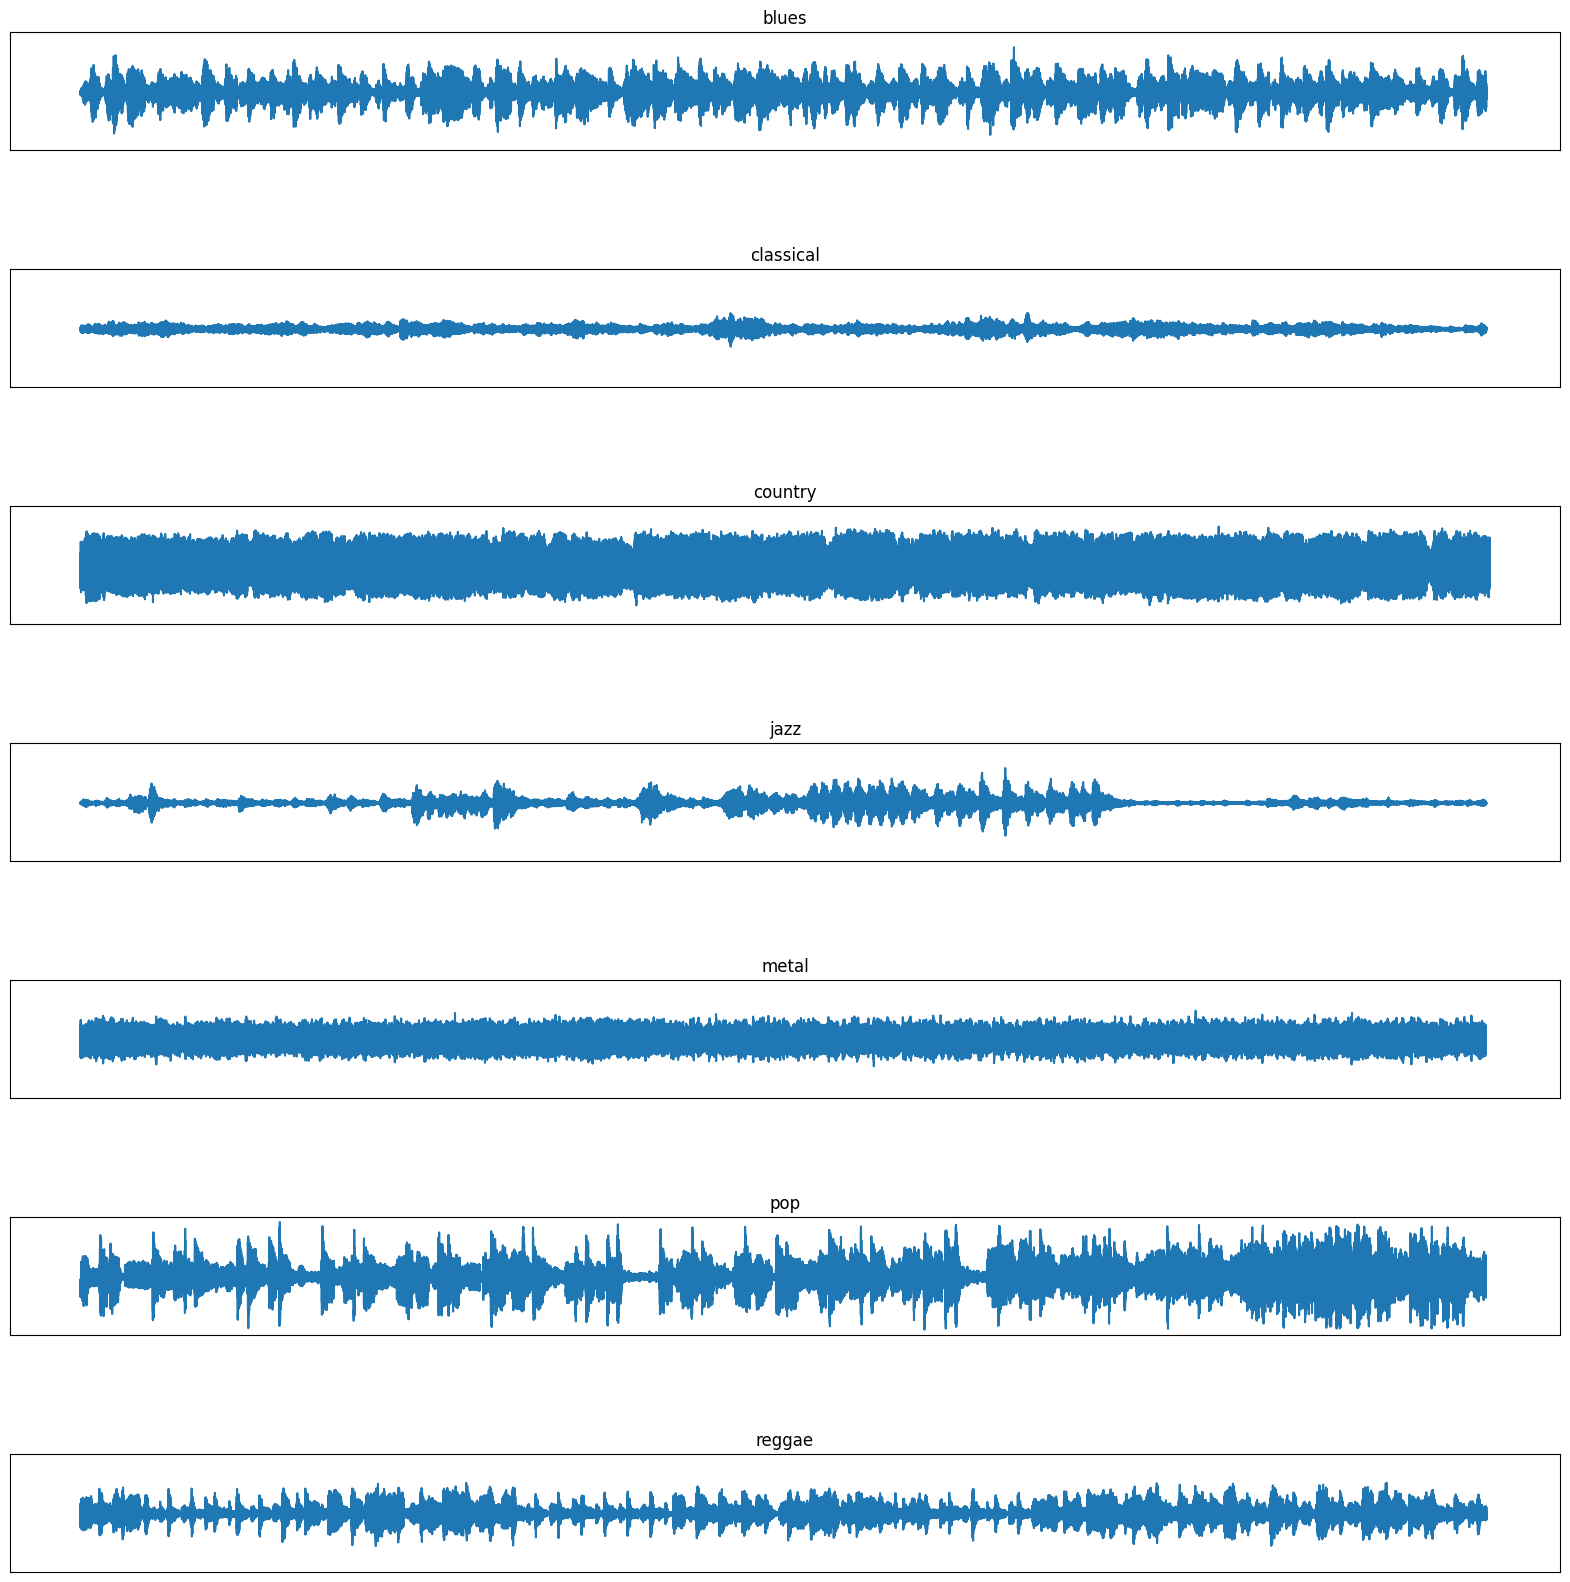

In [10]:
# Plotting Signals

def plot_signals(signals):
    fig, axes = plt.subplots(nrows=7, ncols=1, sharex=True, sharey=True, figsize=(20,20))
    fig.subplots_adjust(hspace=1)
    i = 0
    for x in range(7):
        axes[x].set_title(list(signals.keys())[x])
        axes[x].plot(list(signals.values())[x])
        axes[x].get_xaxis().set_visible(False)
        axes[x].get_yaxis().set_visible(False)
    plt.show()

# plot signals
plot_signals(signals)


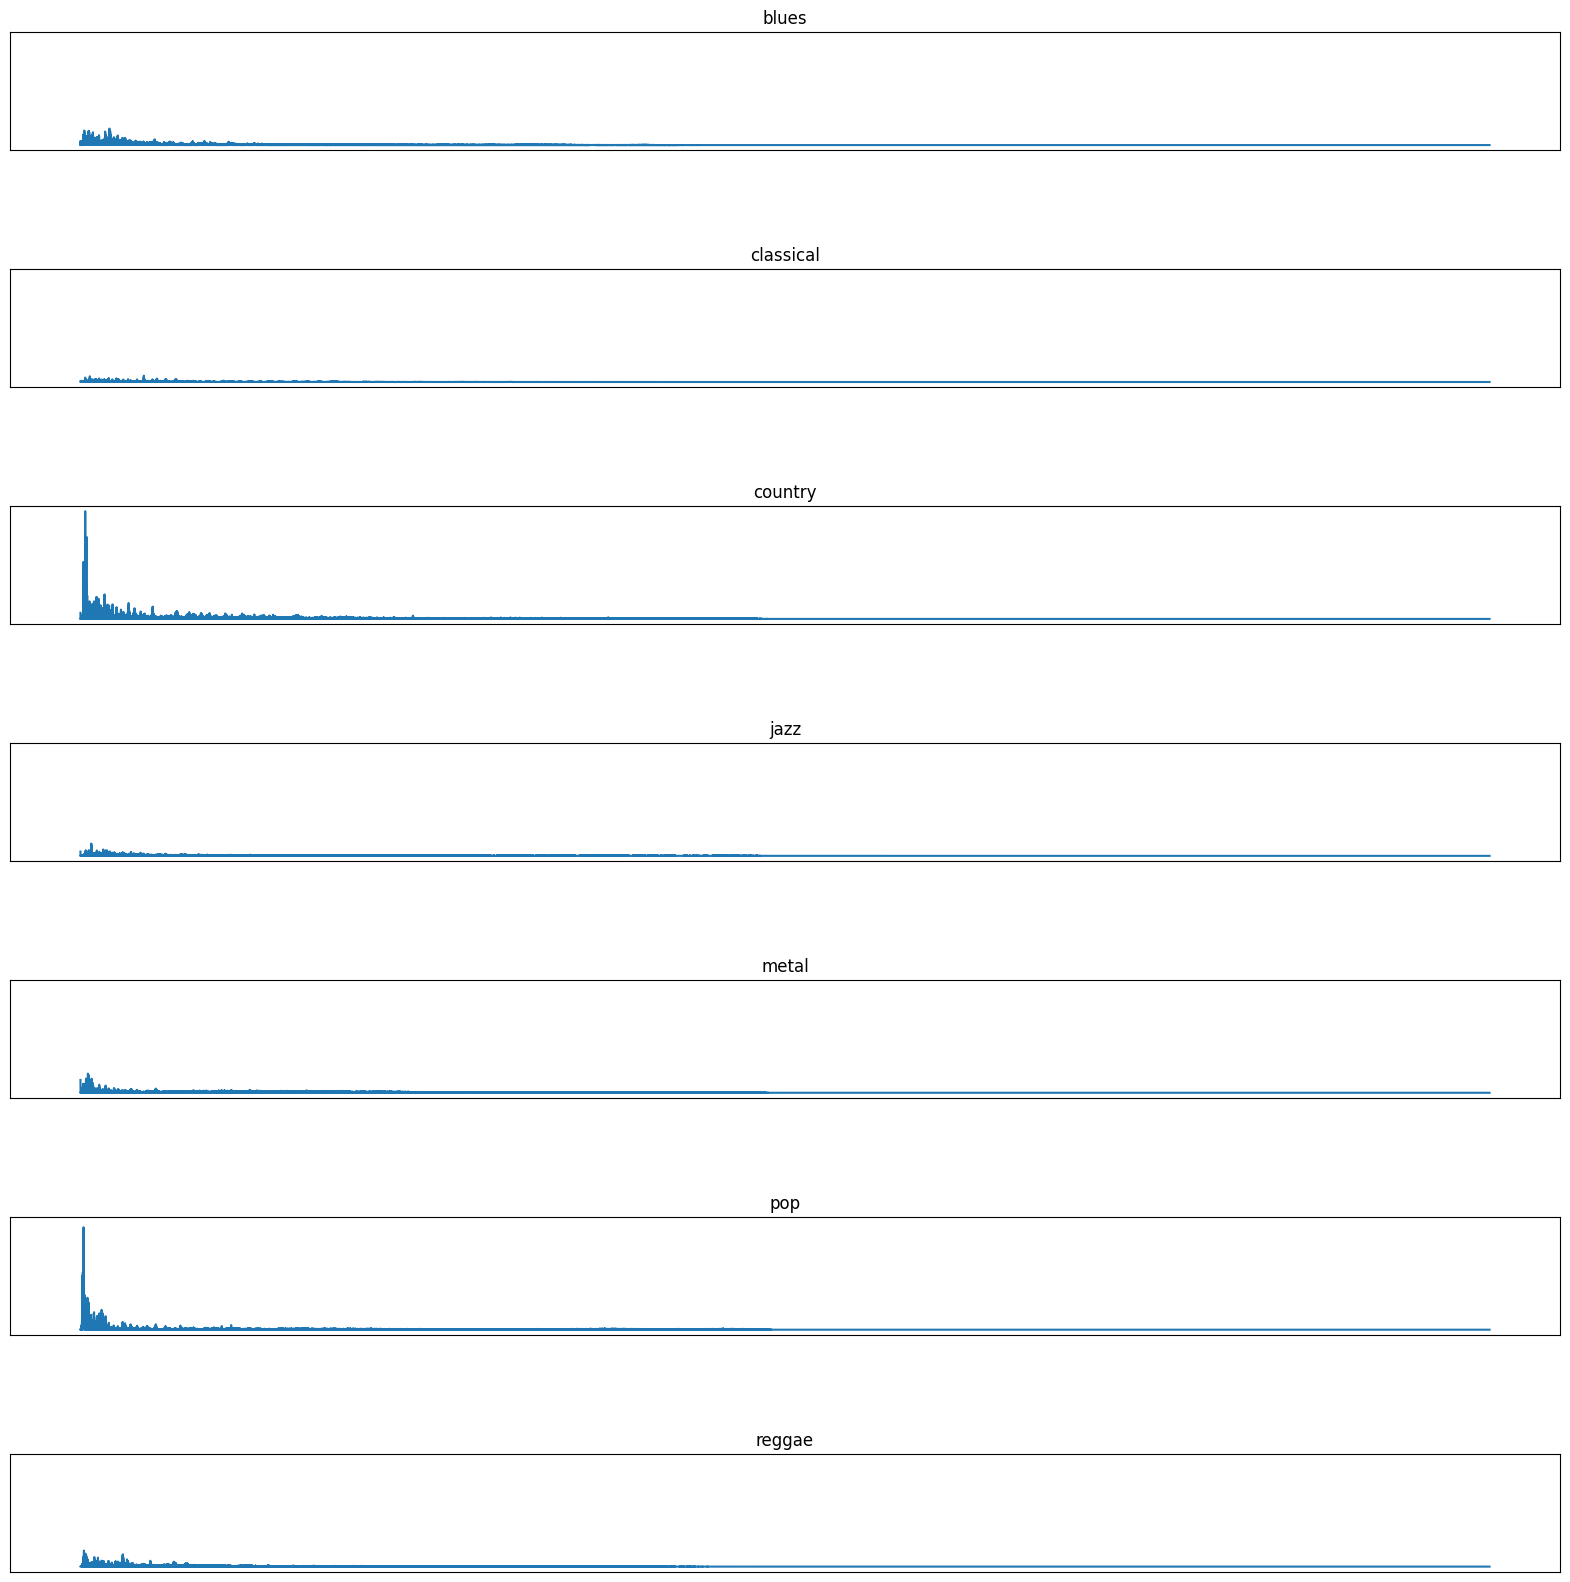

In [11]:
# Plotting ffts

def plot_fft(fft):
    fig, axes = plt.subplots(nrows=7, ncols=1, sharex=True, sharey=True, figsize=(20,20))
    fig.subplots_adjust(hspace=1)
    i = 0
    for x in range(7):
        data = list(fft.values())[x]
        Y, freq = data[0], data[1]
        axes[x].set_title(list(fft.keys())[x])
        axes[x].plot(freq, Y)
        axes[x].get_xaxis().set_visible(False)
        axes[x].get_yaxis().set_visible(False)
    plt.show()

# plot FFT
plot_fft(fft)


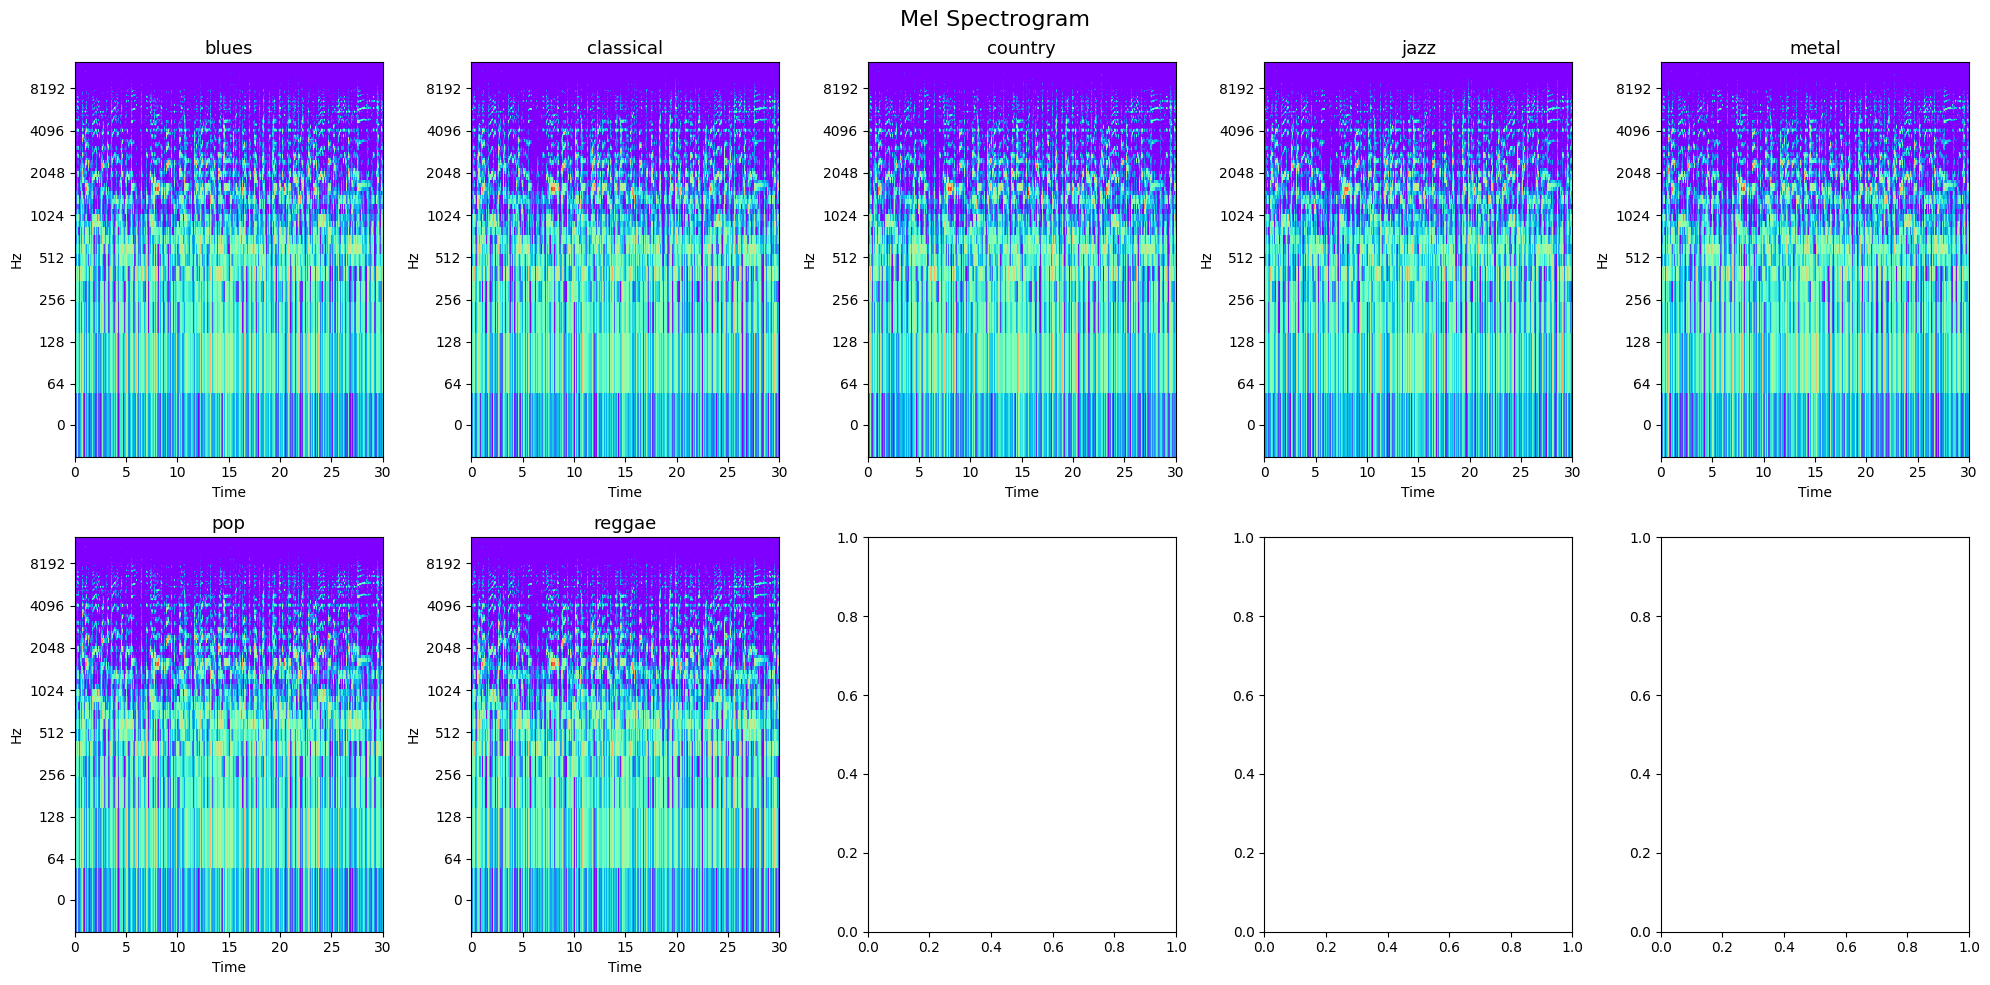

In [12]:
# Mel Spectogram
data = []
hop_length = 512 
ename = list(signals.keys())
for i in fnames:
    y_data, sr_data = librosa.load(fnames[0], sr=25000)  # sr을 명시적으로 지정
    data.append(y_data)

fig, ax = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle('Mel Spectrogram', fontsize=16)

for i in range(7):
    c = librosa.feature.melspectrogram(y=data[i], sr=25000)  # y와 sr을 명시적으로 지정
    S = librosa.amplitude_to_db(c, ref=np.max)
    row = i // 5
    col = i % 5
    librosa.display.specshow(S, sr=25000, hop_length=hop_length, x_axis='time', 
                             y_axis='log', cmap='rainbow', ax=ax[row, col])
    ax[row, col].set_title(ename[i], fontsize=13)

plt.tight_layout()
plt.show()


In [13]:
# mfcc Extractor

def Feature_extractor(file):
    
    audio,sample_rate=librosa.load(file_name,res_type='kaiser_fast')
    mfccs_features=librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=40)
    mfccs_scaled_features =np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features

In [14]:
extracted_features=[]

for index_num,row in tqdm(df.iterrows()):
    file_name = os.path.join(os.path.abspath('C:/jenre/GTZAN/'),str(row["FileName"]))
    final_class_label=row["Class"]
    data=Feature_extractor(file_name)
    extracted_features.append([data,final_class_label])

699it [00:23, 29.27it/s]


In [15]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['features','class'])
extracted_features_df.head(20)

,features,class
0,"[-113.59882, 121.57067, -19.162262, 42.363937,...",blues
1,"[-207.52383, 123.98514, 8.947019, 35.86715, 2....",blues
2,"[-90.757164, 140.44087, -29.084547, 31.686693,...",blues
3,"[-199.57513, 150.0861, 5.663404, 26.855282, 1....",blues
4,"[-160.35417, 126.20948, -35.581394, 22.139256,...",blues
5,"[-177.80176, 118.20316, -17.57063, 30.760927, ...",blues
6,"[-190.0688, 130.27023, -36.362114, 33.03621, 1...",blues
7,"[-179.3723, 136.44833, -26.662588, 39.96545, 5...",blues
8,"[-121.38979, 122.49833, -14.734729, 46.122135,...",blues
9,"[-213.26424, 115.16476, -11.69817, 39.015358, ...",blues


In [16]:
# from sklearn.preprocessing import LabelEncoder
X=np.array(extracted_features_df['features'].tolist())
y=np.array(extracted_features_df["class"].tolist())

In [17]:
X.shape

(699, 40)

In [18]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
LE=LabelEncoder()
y=to_categorical(LE.fit_transform(y))

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [20]:
print("Shape Of X_train:",X_train.shape)
print("Shape Of X_test:",X_test.shape)
print("Shape Of y_train:",y_train.shape)
print("Shape Of y_test:",y_test.shape)

Shape Of X_train: (559, 40)
Shape Of X_test: (140, 40)
Shape Of y_train: (559, 7)
Shape Of y_test: (140, 7)


In [21]:
# Setting labels
num_labels=y.shape[1]

In [22]:
# Creating Our Model

model=Sequential()
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4100      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 200)               4

In [24]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint
# tf.keras.callbacks.ModelCheckpoint
from datetime import datetime

num_epochs=100
num_batch_size=32

checkpointer=ModelCheckpoint(filepath='saved_models/audio_classification.hdf5',verbose=1,save_best_only=True)
start=datetime.now()
history = model.fit(X_train,y_train,batch_size=num_batch_size,epochs=num_epochs,validation_data=(X_test,y_test),callbacks=checkpointer)

duration=datetime.now()-start
print("Training Completed in time: ",duration)

Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 11.6286 - accuracy: 0.1489 
Epoch 1: val_loss improved from inf to 1.98780, saving model to saved_models\audio_classification.hdf5
18/18 [==============================] - 1s 19ms/step - loss: 11.4627 - accuracy: 0.1503 - val_loss: 1.9878 - val_accuracy: 0.3071
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 8.2523 - accuracy: 0.1875
Epoch 2: val_loss improved from 1.98780 to 1.78385, saving model to saved_models\audio_classification.hdf5
18/18 [==============================] - 0s 7ms/step - loss: 4.8456 - accuracy: 0.2111 - val_loss: 1.7839 - val_accuracy: 0.2571
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 5.1979 - accuracy: 0.1250

C:\Users\sanjuk\anaconda3\envs\Sample2\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_loss improved from 1.78385 to 1.67063, saving model to saved_models\audio_classification.hdf5
18/18 [==============================] - 0s 7ms/step - loss: 3.2480 - accuracy: 0.2308 - val_loss: 1.6706 - val_accuracy: 0.3357
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 2.5552 - accuracy: 0.2812
Epoch 4: val_loss did not improve from 1.67063
18/18 [==============================] - 0s 4ms/step - loss: 2.5433 - accuracy: 0.2826 - val_loss: 1.6769 - val_accuracy: 0.2929
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 2.1974 - accuracy: 0.4688
Epoch 5: val_loss did not improve from 1.67063
18/18 [==============================] - 0s 4ms/step - loss: 2.3540 - accuracy: 0.2880 - val_loss: 1.6760 - val_accuracy: 0.3857
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 1.9615 - accuracy: 0.4062
Epoch 6: val_loss did not improve from 1.67063
18/18 [==============================] - 0s 4ms/step - loss: 2.0965 - accuracy:

In [26]:
y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

5/5 [==============================] - 0s 2ms/step


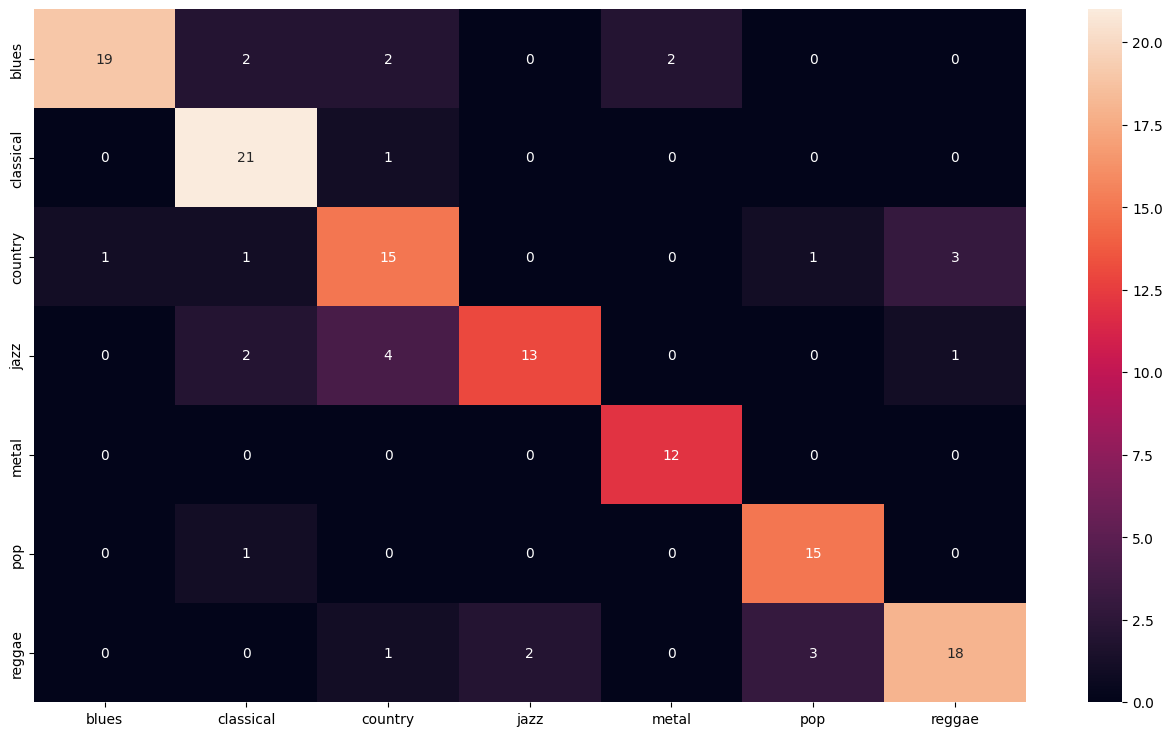

In [27]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(16,9))
sns.heatmap(
    cm,
    annot=True,
    xticklabels=["blues","classical","country","jazz","metal","pop","reggae"],
    yticklabels=["blues","classical","country","jazz","metal","pop","reggae"]
)
plt.show()

In [28]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_accuracy vs val_accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

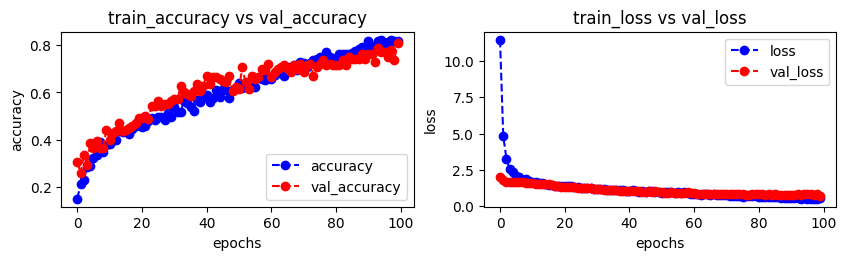

In [29]:
plot_accuracy_loss(history)

In [30]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.8071428537368774


In [31]:
def calculate_cosine_similarity(features_df):
    similarity_matrix = cosine_similarity(features_df)
    sim_df = pd.DataFrame(similarity_matrix, index=features_df.index, columns=features_df.index)
    return sim_df

In [32]:
features_df = pd.DataFrame(X, index=df.index)
sim_df = calculate_cosine_similarity(features_df)

In [65]:
def find_similar_songs(name, n=5):
    series = sim_df[name].sort_values(ascending=False)
    series = series.drop(name)  # Remove the song itself
    return series.head(n).to_frame()

# Example usage
similar_songs = find_similar_songs('C:/jenre/GATZAN/rock.00000.wav')
print(similar_songs)

KeyError: 'C:/jenre/GATZAN/rock.00000.wav'

In [51]:
import os
import random
import IPython.display as ipd 

# 폴더 경로 설정
folder_path = "C:/jenre/GATZAN/"

# 폴더 내 파일 목록 가져오기
file_names = os.listdir(folder_path)

# 랜덤으로 파일 선택
random_file_name = random.choice(file_names)
file_path = os.path.join(folder_path, random_file_name)

# 오디오 파일 로드 및 테스트
audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
mfccs_scaled_features = mfccs_scaled_features.reshape(1, -1)

# 모델 예측
predicted_label = np.argmax(model.predict(mfccs_scaled_features), axis=-1)
prediction_class = LE.inverse_transform(predicted_label)

# 결과 출력
print("파일 이름:", random_file_name)
print("예측된 클래스:", prediction_class)

# 오디오 재생
ipd.Audio(file_path)


1/1 [==============================] - 0s 33ms/step
파일 이름: country.00041.wav
예측된 클래스: ['country']


In [49]:
# Testing an audio from test set

filename="C:/Users/sanjuk/Desktop/Blake-Shelton-God_s-Country-_Official-Music-Video_.wav"
audio,sample_rate=librosa.load(filename,res_type='kaiser_fast')
mfccs_features=librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=40)
mfccs_scaled_features =np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)

predicted_label = np.argmax(model.predict(mfccs_scaled_features), axis=-1)
print(predicted_label)

prediction_class=LE.inverse_transform(predicted_label)
prediction_class

[-5.8857460e+01  1.2318810e+02 -2.8289560e+01  3.0213825e+01
 -7.5665121e+00  1.3055002e+01 -7.1900053e+00  1.5583086e+01
 -6.7523398e+00  1.1867284e+01 -4.6750240e+00  9.2986937e+00
 -5.6333990e+00  7.6455789e+00 -8.5020304e+00  6.4133139e+00
 -8.3332939e+00  4.4087315e+00 -3.0158613e+00  5.4272318e+00
 -3.0943394e+00  1.9574192e+00 -3.8746786e+00 -4.0507668e-01
 -1.7420661e+00  3.8343456e-01 -3.3028257e+00  2.1944818e-01
 -1.9468693e+00 -1.6873755e+00 -3.6947088e+00 -2.4083076e+00
 -2.4128160e+00 -1.3604081e+00 -1.1315647e+00 -4.6689183e-01
 -2.3726723e+00  1.8011723e-01  8.5042395e-02 -1.3921831e+00]
[[-5.8857460e+01  1.2318810e+02 -2.8289560e+01  3.0213825e+01
  -7.5665121e+00  1.3055002e+01 -7.1900053e+00  1.5583086e+01
  -6.7523398e+00  1.1867284e+01 -4.6750240e+00  9.2986937e+00
  -5.6333990e+00  7.6455789e+00 -8.5020304e+00  6.4133139e+00
  -8.3332939e+00  4.4087315e+00 -3.0158613e+00  5.4272318e+00
  -3.0943394e+00  1.9574192e+00 -3.8746786e+00 -4.0507668e-01
  -1.7420661e+00 

array(['country'], dtype='<U9')

In [35]:
# .wav 파일이 포함된 디렉토리 경로
directory_path = "C:/jenre/GTZANtest"

# 디렉토리 내의 모든 .wav 파일 목록 가져오기
wav_files = glob.glob(os.path.join(directory_path, '*.wav'))

# 모든 .wav 파일을 순회하며 처리
for filename in wav_files:
    try:
        # 오디오 파일 로드
        audio, sample_rate = librosa.load(filename, res_type='kaiser_fast')
        
        # MFCC 특징 추출
        mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

        print(mfccs_scaled_features)
        mfccs_scaled_features = mfccs_scaled_features.reshape(1, -1)
        print(mfccs_scaled_features)

        predicted_label = np.argmax(model.predict(mfccs_scaled_features), axis=-1)
        print(predicted_label)

        prediction_class = LE.inverse_transform(predicted_label)
        print(f'파일명: {filename}')
        print(f'예측된 클래스: {prediction_class[0]}')

    except Exception as e:
        print(f'{filename} 처리 중 오류 발생: {e}')


[ 14.14103    66.45092   -27.471123   44.08353   -13.557671   11.541184
 -16.22268    15.475181   -7.8473616  16.920221  -12.280884   12.8534565
 -12.061707    6.883307   -8.538055    7.0755286  -9.771858    9.926412
  -5.3449845   3.4393413 -10.695875    6.055919   -4.716838    1.9550378
  -8.023753    3.4409401  -4.2753615   3.466299   -4.4384623   1.2469345
  -4.300154    1.6110442  -3.2281578  -1.2988054  -7.8190656  -3.4441323
  -5.221817    2.3883276  -1.891358   -1.3129085]
[[ 14.14103    66.45092   -27.471123   44.08353   -13.557671   11.541184
  -16.22268    15.475181   -7.8473616  16.920221  -12.280884   12.8534565
  -12.061707    6.883307   -8.538055    7.0755286  -9.771858    9.926412
   -5.3449845   3.4393413 -10.695875    6.055919   -4.716838    1.9550378
   -8.023753    3.4409401  -4.2753615   3.466299   -4.4384623   1.2469345
   -4.300154    1.6110442  -3.2281578  -1.2988054  -7.8190656  -3.4441323
   -5.221817    2.3883276  -1.891358   -1.3129085]]
1/1 [===============

In [ ]:
클래식:7
블루스:2
컨트리:5
재즈:4
메탈:8
팝:0
레게:5